# Explore here

It's recommended to use this notebook for exploration purposes.

In [5]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Importar las librerías necesarias
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd

# Seleccionar el recurso a descargar
url_recurso = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"

# Esperar 60 segundos antes de hacer la solicitud (por respeto al servidor)
time.sleep(60)

# Hacer la solicitud HTTP con encabezado para simular un navegador
respuesta = requests.get(
    url_recurso,
    headers={
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) "
                      "AppleWebKit/537.36 (KHTML, como Gecko) "
                      "Chrome/50.0.2661.102 Safari/537.36"
    }
)

# Si la solicitud fue exitosa (código 200), analizar el contenido HTML
if respuesta.status_code == 200:
    sopa = BeautifulSoup(respuesta.text, 'html.parser')
else:
    print(f"Fallo en la conexión. Código de estado: {respuesta.status_code}")

# Extraer todas las tablas HTML encontradas en la página
tablas = sopa.find_all("table")

In [8]:
# Inicializar listas vacías para almacenar las fechas y los valores
fechas = []
ingresos = []

# Buscar la tabla que contiene el texto "Tesla Quarterly Revenue"
tabla_ingresos = next(
    (tabla for tabla in tablas if "Tesla Quarterly Revenue" in tabla.text),
    None
)

# Si se encontró la tabla, extraer los datos
if tabla_ingresos:
    filas = tabla_ingresos.find_all('tr')
    
    for fila in filas:
        celdas = fila.find_all('td')
        
        # Asegurarse de que hay al menos dos celdas (fecha y valor)
        if len(celdas) >= 2:
            fecha = celdas[0].get_text(strip=True)
            ingreso = celdas[1].get_text(strip=True)
            
            fechas.append(fecha)
            ingresos.append(ingreso)

    print(f"Fechas:\n{fechas}\n")
    print(f"Ingresos:\n{ingresos}")
else:
    print("No se encontró la tabla de ingresos trimestrales de Tesla.")

Fechas:
['2025-03-31', '2024-12-31', '2024-09-30', '2024-06-30', '2024-03-31', '2023-12-31', '2023-09-30', '2023-06-30', '2023-03-31', '2022-12-31', '2022-09-30', '2022-06-30', '2022-03-31', '2021-12-31', '2021-09-30', '2021-06-30', '2021-03-31', '2020-12-31', '2020-09-30', '2020-06-30', '2020-03-31', '2019-12-31', '2019-09-30', '2019-06-30', '2019-03-31', '2018-12-31', '2018-09-30', '2018-06-30', '2018-03-31', '2017-12-31', '2017-09-30', '2017-06-30', '2017-03-31', '2016-12-31', '2016-09-30', '2016-06-30', '2016-03-31', '2015-12-31', '2015-09-30', '2015-06-30', '2015-03-31', '2014-12-31', '2014-09-30', '2014-06-30', '2014-03-31', '2013-12-31', '2013-09-30', '2013-06-30', '2013-03-31', '2012-12-31', '2012-09-30', '2012-06-30', '2012-03-31', '2011-12-31', '2011-09-30', '2011-06-30', '2011-03-31', '2010-12-31', '2010-09-30', '2010-06-30', '2010-03-31', '2009-12-31', '2009-09-30', '2009-06-30']

Ingresos:
['$19,335', '$25,707', '$25,182', '$25,500', '$21,301', '$25,167', '$23,350', '$24,9

In [9]:
# Preparar el DataFrame a partir de las listas de fechas e ingresos
df_ingresos = pd.DataFrame(list(zip(fechas, ingresos)), columns=["Fecha", "Ingreso"])

print("DataFrame sin preparar:\n", df_ingresos)

# Reemplazar valores vacíos por None y eliminar filas con datos faltantes
df_ingresos = df_ingresos.replace("", None).dropna()

# Limpiar los valores de la columna 'Ingreso' y convertirlos a enteros
df_ingresos["Ingreso"] = (
    df_ingresos["Ingreso"]
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(int)
)

print("DataFrame después del procesamiento:\n", df_ingresos)

DataFrame sin preparar:
          Fecha  Ingreso
0   2025-03-31  $19,335
1   2024-12-31  $25,707
2   2024-09-30  $25,182
3   2024-06-30  $25,500
4   2024-03-31  $21,301
..         ...      ...
59  2010-06-30      $28
60  2010-03-31      $21
61  2009-12-31         
62  2009-09-30      $46
63  2009-06-30      $27

[64 rows x 2 columns]
DataFrame después del procesamiento:
          Fecha  Ingreso
0   2025-03-31    19335
1   2024-12-31    25707
2   2024-09-30    25182
3   2024-06-30    25500
4   2024-03-31    21301
..         ...      ...
58  2010-09-30       31
59  2010-06-30       28
60  2010-03-31       21
62  2009-09-30       46
63  2009-06-30       27

[63 rows x 2 columns]


In [10]:
# Conectarse (o crear) a una base de datos SQLite llamada 'tesla.db'
conexion = sqlite3.connect('tesla.db')
cursor = conexion.cursor()

# Crear la tabla 'ingresos' si no existe
try:
    cursor.execute('''
        CREATE TABLE ingresos (
            fecha TEXT,
            ingreso REAL
        )
    ''')
    print("Tabla 'ingresos' creada exitosamente.")
except sqlite3.OperationalError:
    print("La tabla ya existe.")

Tabla 'ingresos' creada exitosamente.


In [11]:
# Convertir el DataFrame en una lista de tuplas para insertar en la base de datos
tuplas_ingresos = list(df_ingresos.to_records(index=False))

# Insertar los datos en la tabla 'ingresos'
cursor.executemany("INSERT INTO ingresos VALUES (?, ?)", tuplas_ingresos)

# Confirmar (guardar) los cambios en la base de datos
conexion.commit()

In [13]:
# Consultar todos los datos de la tabla 'ingresos'
resultados_db = pd.read_sql_query("SELECT * FROM ingresos", conexion)
print("Todos los registros en la tabla 'ingresos':\n", resultados_db)

# Consultar solo los registros donde el ingreso es mayor a 15,000
resultados_filtrados = pd.read_sql_query(
    "SELECT * FROM ingresos WHERE ingreso > 15000", conexion
)
print("Registros con ingreso mayor a 15,000:\n", resultados_filtrados)

Todos los registros en la tabla 'ingresos':
          fecha                              ingreso
0   2025-03-31     b'\x87K\x00\x00\x00\x00\x00\x00'
1   2024-12-31        b'kd\x00\x00\x00\x00\x00\x00'
2   2024-09-30        b'^b\x00\x00\x00\x00\x00\x00'
3   2024-06-30     b'\x9cc\x00\x00\x00\x00\x00\x00'
4   2024-03-31        b'5S\x00\x00\x00\x00\x00\x00'
..         ...                                  ...
58  2010-09-30  b'\x1f\x00\x00\x00\x00\x00\x00\x00'
59  2010-06-30  b'\x1c\x00\x00\x00\x00\x00\x00\x00'
60  2010-03-31  b'\x15\x00\x00\x00\x00\x00\x00\x00'
61  2009-09-30     b'.\x00\x00\x00\x00\x00\x00\x00'
62  2009-06-30  b'\x1b\x00\x00\x00\x00\x00\x00\x00'

[63 rows x 2 columns]
Registros con ingreso mayor a 15,000:
          fecha                              ingreso
0   2025-03-31     b'\x87K\x00\x00\x00\x00\x00\x00'
1   2024-12-31        b'kd\x00\x00\x00\x00\x00\x00'
2   2024-09-30        b'^b\x00\x00\x00\x00\x00\x00'
3   2024-06-30     b'\x9cc\x00\x00\x00\x00\x00\x00'
4   2024-

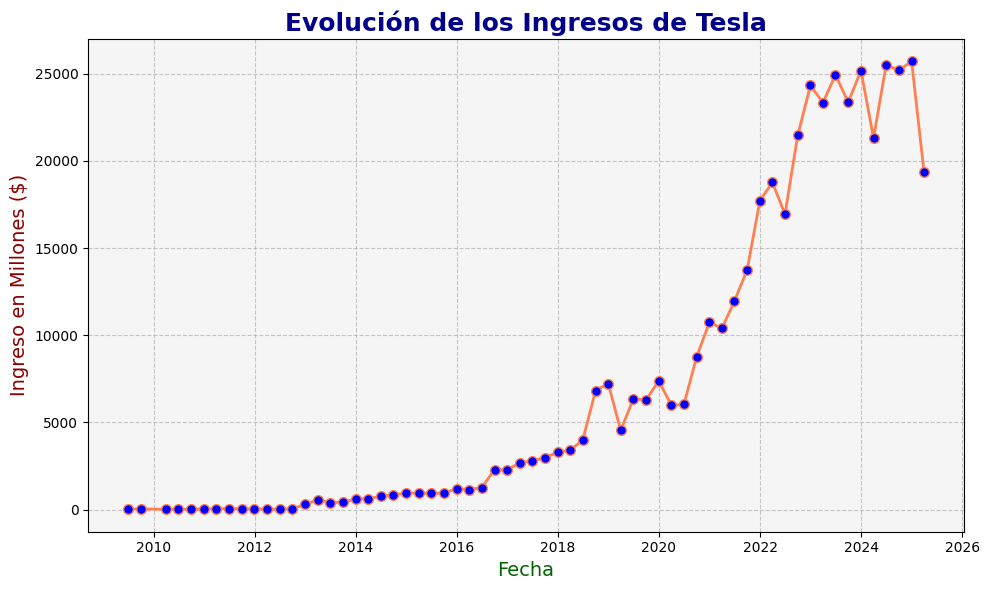

In [15]:
# Convertir la columna 'Fecha' a tipo datetime
df_ingresos['Fecha'] = pd.to_datetime(df_ingresos['Fecha'])

# Configurar el gráfico
plt.figure(figsize=(10,6))  # Cambiar el tamaño de la figura
plt.title('Evolución de los Ingresos de Tesla', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Fecha', fontsize=14, color='darkgreen')
plt.ylabel('Ingreso en Millones ($)', fontsize=14, color='darkred')

# Graficar la serie temporal (línea) con estilo personalizado
plt.plot(df_ingresos['Fecha'], df_ingresos['Ingreso'], 
         marker='o', markerfacecolor='blue', 
         linestyle='-', color='coral', linewidth=2, markersize=7)

# Agregar un fondo gris claro y una cuadrícula (grid)
plt.gca().set_facecolor('whitesmoke')
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()

/tmp/ipykernel_3778/930788575.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ingresos_anuales, x=ingresos_anuales.index, y="Ingreso",


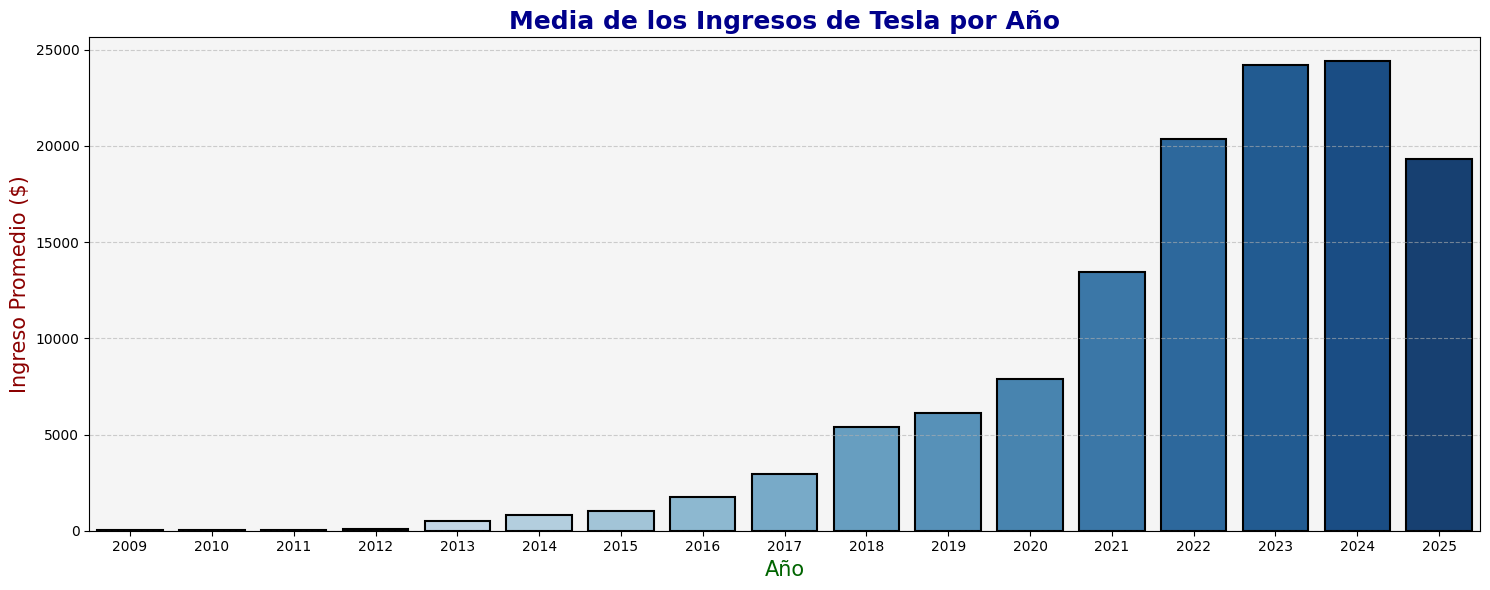

In [16]:
# Agrupar los ingresos por año y calcular la media
ingresos_anuales = df_ingresos.groupby(df_ingresos["Fecha"].dt.year)['Ingreso'].mean()

# Convertir el resultado a un DataFrame
ingresos_anuales = pd.DataFrame(ingresos_anuales)

# Crear el gráfico de barras con más personalización
plt.figure(figsize=(15, 6))  # Cambiar el tamaño de la figura

# Título y etiquetas con estilo
plt.title('Media de los Ingresos de Tesla por Año', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Año', fontsize=15, color='darkgreen')
plt.ylabel('Ingreso Promedio ($)', fontsize=15, color='darkred')

# Crear el gráfico de barras usando seaborn
sns.barplot(data=ingresos_anuales, x=ingresos_anuales.index, y="Ingreso", 
            palette='Blues', edgecolor='black', linewidth=1.5)

# Agregar un fondo blanco y ajustar el estilo de la cuadrícula
plt.gca().set_facecolor('whitesmoke')
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

/tmp/ipykernel_3778/2695960841.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ingresos_totales_anuales, x=ingresos_totales_anuales.index, y="Ingreso",


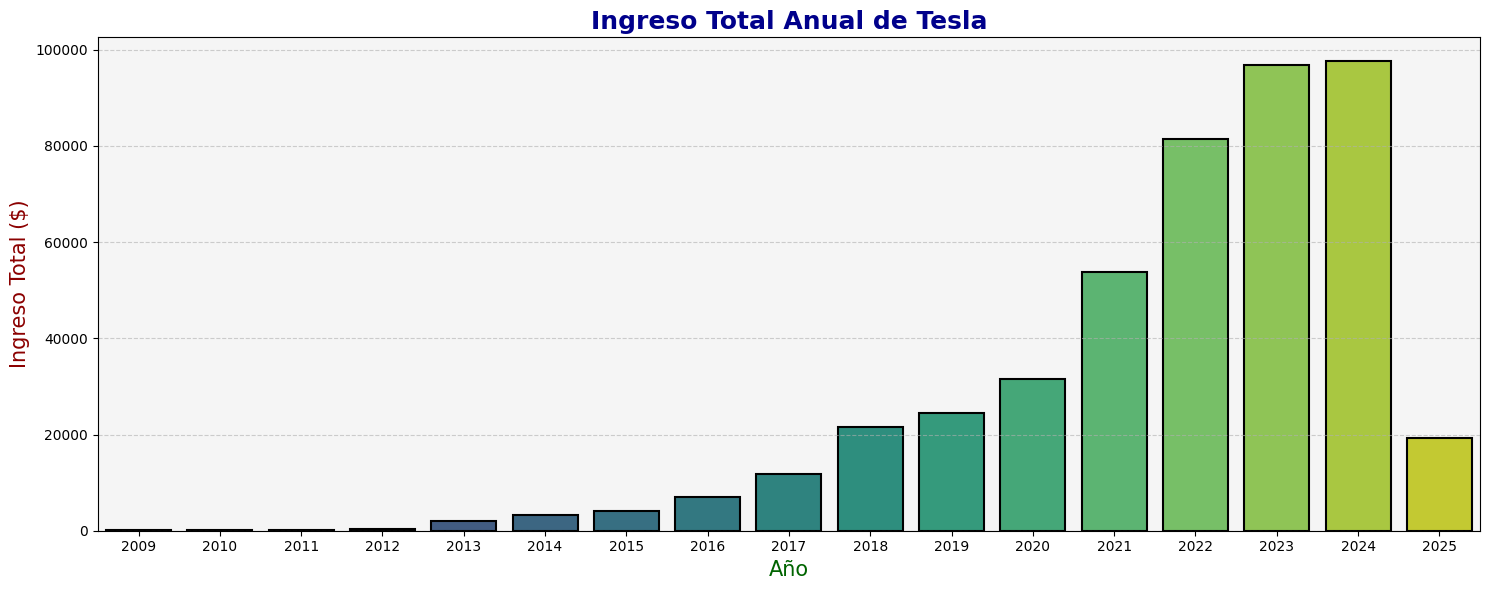

In [17]:
# Agrupar los ingresos por año y calcular el total anual
ingresos_totales_anuales = df_ingresos.groupby(df_ingresos["Fecha"].dt.year)['Ingreso'].sum()

# Convertir el resultado a un DataFrame
ingresos_totales_anuales = pd.DataFrame(ingresos_totales_anuales)

# Crear el gráfico de barras con más personalización
plt.figure(figsize=(15, 6))  # Ajustar el tamaño del gráfico

# Título y etiquetas con estilo
plt.title('Ingreso Total Anual de Tesla', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Año', fontsize=15, color='darkgreen')
plt.ylabel('Ingreso Total ($)', fontsize=15, color='darkred')

# Crear el gráfico de barras con seaborn
sns.barplot(data=ingresos_totales_anuales, x=ingresos_totales_anuales.index, y="Ingreso", 
            palette='viridis', edgecolor='black', linewidth=1.5)

# Agregar fondo blanco y mejorar la cuadrícula
plt.gca().set_facecolor('whitesmoke')
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()